<font color='green' size='7'>**Итоговая аттестация**</font>  
<font size='6' color='#11a642'>**Задание:**</font>  

Итоговая аттестация основана на конкурсе:  
[https://www.kaggle.com/competitions/playground-series-s5e7/overview](https://www.kaggle.com/competitions/playground-series-s5e7/overview).  

<font size='4' color='#11a642'>**Ваша задача:**</font> Построить модель с лучшими метриками.  
<font size='4' color='#11a642'>**Что можно использовать:**</font> Любые модели и методы обработки данных.  
<font size='4' color='#11a642'>**Сколько моделей нужно построить:**</font> Столько, сколько вы считаете достаточным для обоснования выбора наилучшей модели.  
<font size='4' color='#11a642'>**Важно:**</font> Каждый этап должен сопровождаться комментариями и выводами.  

<font size='4' color='green'>**Рекомендованные этапы:**</font>  
- Провести EDA.  
- Выявить и обработать проблемы в данных (если это улучшит метрики).  
- Построить несколько моделей с разными подходами.  
- Выбрать наилучшую модель.  
- *Опционально:* Участие в Kaggle (загрузить решение и указать позицию в leaderboard).  

На момент выдачи задания конкурс активен, поэтому у вас есть возможность не только выполнить учебную задачу, но и поучаствовать в соревновании.  

<font size='4' color='green'>**Форма сдачи:**</font>  
- Файл в формате `.ipynb` (Jupyter Notebook).  
- Перед загрузкой убедитесь, что ноутбук запускается без ошибок (`Kernel → Restart & Run All`).  

Удачи в выполнении задания!  

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузка данных
try:
  df = pd.read_csv('/train.csv')
except:
  df = pd.read_csv('train.csv')




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB
None
Размер датасета: 0.0035 ГБ
Количество строк: 18524
Количество столбцов: 9
Распределение классов:
   Extrovert: 13699 (74.0%)
   Introvert: 4825 (26.0%)
Классы НЕ сбалансированы


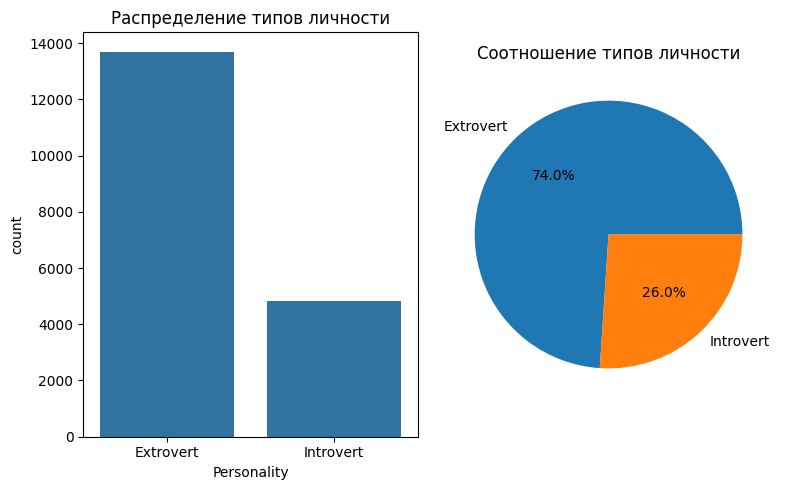

Числовые признаки: ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']


,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,17334.00,17344.00,17058.00,17470.00,17260.00
mean,3.14,5.27,4.04,8.00,4.98
std,3.00,2.75,2.06,4.22,2.88
min,0.00,0.00,0.00,0.00,0.00
25%,1.00,3.00,3.00,5.00,3.00
50%,2.00,5.00,4.00,8.00,5.00
75%,4.00,8.00,6.00,12.00,7.00
max,11.00,10.00,7.00,15.00,10.00


In [3]:
# структура данных
print(df.info())

# разведочный анализ данных
df.head()

# Сколько ГБ  датасет
dataset_size_gb = df.memory_usage(deep=True).sum() / (1024**3)
print(f"Размер датасета: {dataset_size_gb:.4f} ГБ")

# Сколько строк и столбцов
print(f"Количество строк: {df.shape[0]}")
print(f"Количество столбцов: {df.shape[1]}")


# АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Personality)
# Распределение классов
personality_counts = df['Personality'].value_counts()
print(f"Распределение классов:")
for label, count in personality_counts.items():
    percentage = count / len(df) * 100
    print(f"   {label}: {count} ({percentage:.1f}%)")

# Проверка на сбалансированность
is_balanced = abs(personality_counts.iloc[0] - personality_counts.iloc[1]) / len(df) < 0.1
print(f"Классы {'сбалансированы' if is_balanced else 'НЕ сбалансированы'}")

# Визуализация
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Personality')
plt.title('Распределение типов личности')

plt.subplot(1, 2, 2)
plt.pie(personality_counts.values, labels=personality_counts.index, autopct='%1.1f%%')
plt.title('Соотношение типов личности')
plt.tight_layout()
plt.show()


# АНАЛИЗ ЧИСЛОВЫХ ПРИЗНАКОВ
# Выделяем числовые признаки (исключаем id)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['id'])
print(f"Числовые признаки: {list(numeric_cols)}")

# Описательная статистика
desc_stats = df[numeric_cols].describe().round(2)
desc_stats


In [4]:
# АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
categorical_cols = df.select_dtypes(include=['object']).columns.drop(['Personality'])
print(f"Категориальные признаки: {list(categorical_cols)}")

for col in categorical_cols:
    print(f"\n Признак: {col}")
    print(f"   Уникальных значений: {df[col].nunique()}")
    value_counts = df[col].value_counts(dropna=False)
    print("   Распределение:")
    for value, count in value_counts.items():
        percentage = count / len(df) * 100
        print(f"      {value}: {count} ({percentage:.1f}%)")

Категориальные признаки: ['Stage_fear', 'Drained_after_socializing']

 Признак: Stage_fear
   Уникальных значений: 2
   Распределение:
      No: 12609 (68.1%)
      Yes: 4022 (21.7%)
      nan: 1893 (10.2%)

 Признак: Drained_after_socializing
   Уникальных значений: 2
   Распределение:
      No: 13313 (71.9%)
      Yes: 4062 (21.9%)
      nan: 1149 (6.2%)


Найдены пропуски:
                           Пропусков  Процент
Stage_fear                      1893    10.22
Going_outside                   1466     7.91
Post_frequency                  1264     6.82
Time_spent_Alone                1190     6.42
Social_event_attendance         1180     6.37
Drained_after_socializing       1149     6.20
Friends_circle_size             1054     5.69


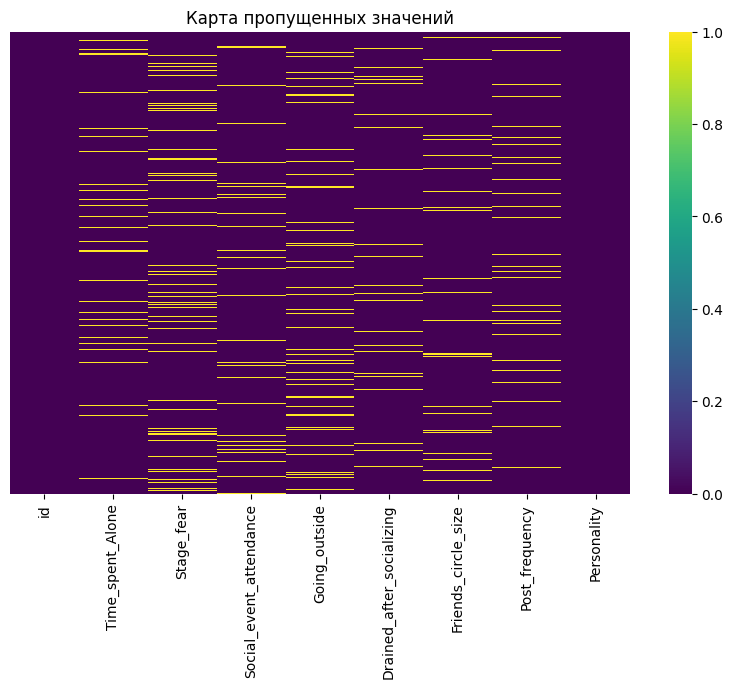

In [5]:
# АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_info = pd.DataFrame({
    'Пропусков': missing_data,
    'Процент': missing_percent.round(2)
})
missing_info = missing_info[missing_info['Пропусков'] > 0].sort_values('Пропусков', ascending=False)

if len(missing_info) > 0:
    print("Найдены пропуски:")
    print(missing_info)
    
    # Визуализация пропусков
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Карта пропущенных значений')
    plt.show()
else:
    print("Пропущенных значений не найдено")

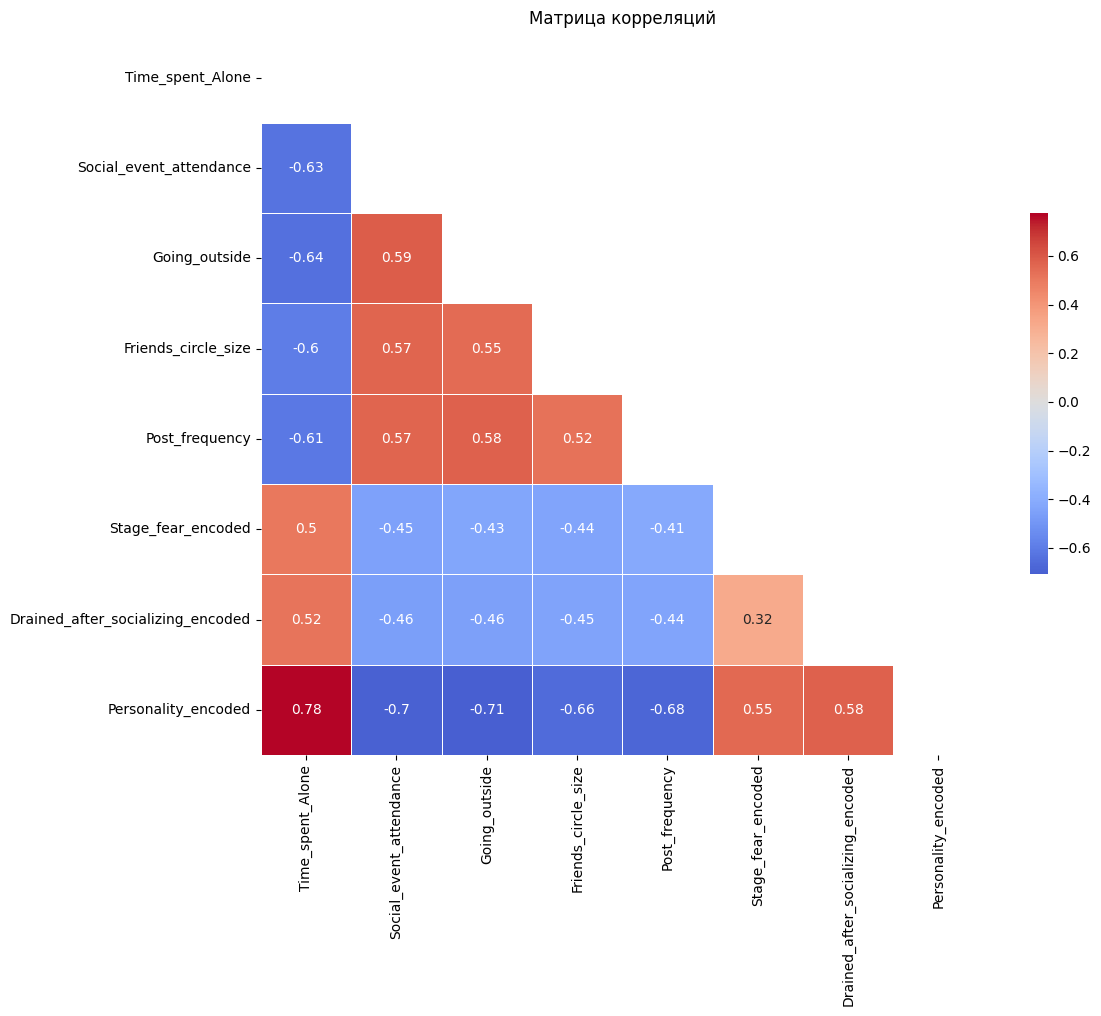


КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:
   Time_spent_Alone: 0.777
   Going_outside: -0.709
   Social_event_attendance: -0.703
   Post_frequency: -0.678
   Friends_circle_size: -0.657
   Drained_after_socializing_encoded: 0.578
   Stage_fear_encoded: 0.553


In [6]:

# КОРРЕЛЯЦИОННЫЙ АНАЛИЗ
# Создаем копию данных для анализа корреляций
df_corr = df.copy()

# Кодируем категориальные переменные для анализа корреляций
le = LabelEncoder()
for col in categorical_cols:
    df_corr[col + '_encoded'] = le.fit_transform(df_corr[col].fillna('Missing'))

df_corr['Personality_encoded'] = le.fit_transform(df_corr['Personality'])

# Вычисляем корреляции
correlation_cols = numeric_cols.tolist() + [col + '_encoded' for col in categorical_cols] + ['Personality_encoded']
corr_matrix = df_corr[correlation_cols].corr()

# Визуализация
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Матрица корреляций')
plt.tight_layout()
plt.show()

# Корреляции с целевой переменной
target_corr = corr_matrix['Personality_encoded'].sort_values(key=abs, ascending=False)[1:]
print(f"\nКОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:")
for feature, corr_val in target_corr.items():
    print(f"   {feature}: {corr_val:.3f}")

In [7]:
# ПОДГОТОВКА ДАННЫХ К ОБУЧЕНИЮ
# Разделение признаков и целевой переменной
X = df.drop(['Personality', 'id'], axis=1)
y = df['Personality']

print(f"Признаки: {X.shape[1]} столбцов")
print(f"Целевая переменная: {y.nunique()} класса")

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Признаки: 7 столбцов
Целевая переменная: 2 класса
Размер обучающей выборки: (14819, 7)
Размер тестовой выборки: (3705, 7)


In [8]:
# Определяем числовые и категориальные признаки
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print(f"Числовые признаки: {list(numeric_features)}")
print(f"Категориальные признаки: {list(categorical_features)}")

# Создаем трансформеры
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Объединяем трансформеры
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Пайплайн предобработки создан")

Числовые признаки: ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
Категориальные признаки: ['Stage_fear', 'Drained_after_socializing']
Пайплайн предобработки создан


In [9]:

# ПОСТРОЕНИЕ МОДЕЛЕЙ МАШИННОГО ОБУЧЕНИЯ
# Словарь моделей для тестирования
models = {
    'Логистическая регрессия': LogisticRegression(random_state=42, max_iter=1000),
    'Случайный лес': RandomForestClassifier(random_state=42, n_estimators=100),
    'Градиентный бустинг': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True),
    'K-ближайших соседей': KNeighborsClassifier()
}

# Результаты моделей
results = {}

for name, model in models.items():
    print(f"\nОбучение модели: {name}")
    
    # Создаем полный пайплайн
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Обучение модели
    pipeline.fit(X_train, y_train)
    
    # Предсказания
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test == 'Extrovert', y_pred_proba)
    
    # Кросс-валидация
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    
    results[name] = {
        'pipeline': pipeline,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   ROC-AUC: {roc_auc:.4f}")
    print(f"   CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


Обучение модели: Логистическая регрессия
   Accuracy: 0.9717
   ROC-AUC: 0.0424
   CV Score: 0.9681 (±0.0024)

Обучение модели: Случайный лес
   Accuracy: 0.9671
   ROC-AUC: 0.0320
   CV Score: 0.9632 (±0.0019)

Обучение модели: Градиентный бустинг
   Accuracy: 0.9711
   ROC-AUC: 0.0261
   CV Score: 0.9678 (±0.0018)

Обучение модели: SVM
   Accuracy: 0.9714
   ROC-AUC: 0.0286
   CV Score: 0.9681 (±0.0025)

Обучение модели: K-ближайших соседей
   Accuracy: 0.9711
   ROC-AUC: 0.0344
   CV Score: 0.9677 (±0.0027)


                 Модель  Accuracy  ROC-AUC  CV Mean  CV Std
Логистическая регрессия    0.9717   0.0424   0.9681  0.0024
    K-ближайших соседей    0.9711   0.0344   0.9677  0.0027
          Случайный лес    0.9671   0.0320   0.9632  0.0019
                    SVM    0.9714   0.0286   0.9681  0.0025
    Градиентный бустинг    0.9711   0.0261   0.9678  0.0018


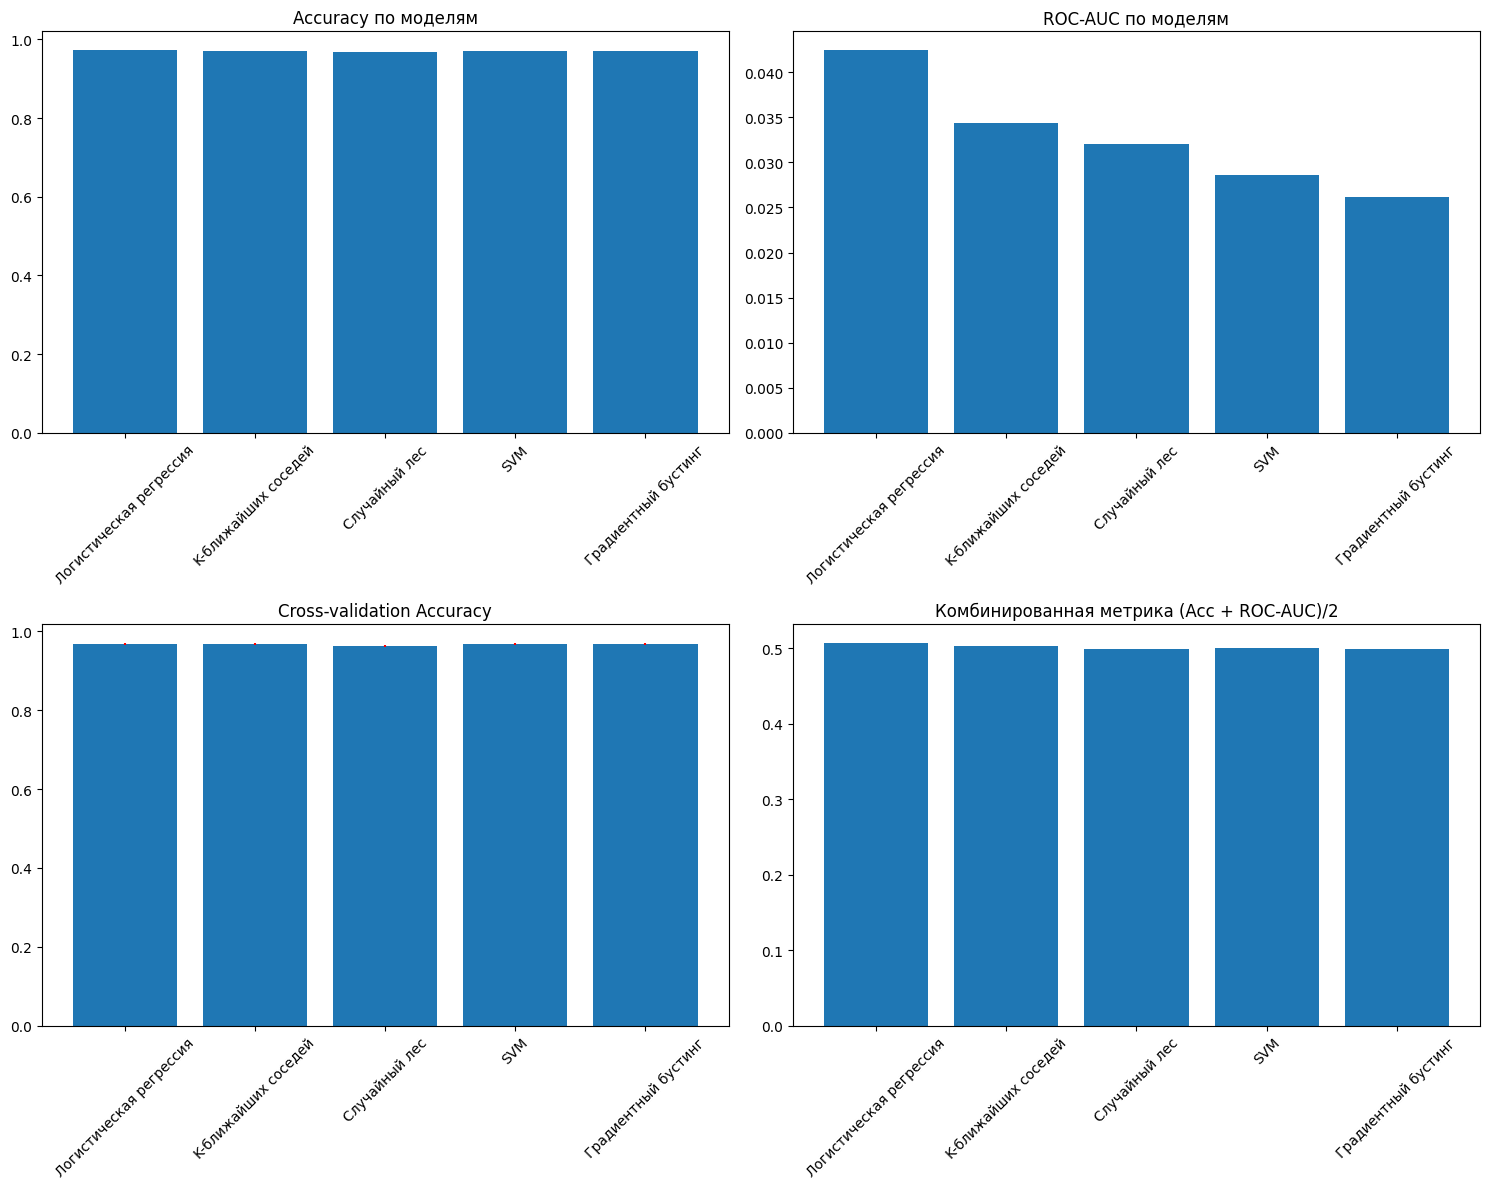

In [10]:
# СРАВНЕНИЕ МОДЕЛЕЙ

# Создаем DataFrame с результатами
comparison_df = pd.DataFrame({
    'Модель': results.keys(),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'ROC-AUC': [results[name]['roc_auc'] for name in results.keys()],
    'CV Mean': [results[name]['cv_mean'] for name in results.keys()],
    'CV Std': [results[name]['cv_std'] for name in results.keys()]
}).round(4)

comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False)
print(comparison_df.to_string(index=False))

# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy
axes[0,0].bar(comparison_df['Модель'], comparison_df['Accuracy'])
axes[0,0].set_title('Accuracy по моделям')
axes[0,0].tick_params(axis='x', rotation=45)

# ROC-AUC
axes[0,1].bar(comparison_df['Модель'], comparison_df['ROC-AUC'])
axes[0,1].set_title('ROC-AUC по моделям')
axes[0,1].tick_params(axis='x', rotation=45)

# Cross-validation scores
axes[1,0].bar(comparison_df['Модель'], comparison_df['CV Mean'])
axes[1,0].errorbar(range(len(comparison_df)), comparison_df['CV Mean'], 
                   yerr=comparison_df['CV Std'], fmt='none', color='red')
axes[1,0].set_title('Cross-validation Accuracy')
axes[1,0].tick_params(axis='x', rotation=45)

# Combined metric
combined_score = (comparison_df['Accuracy'] + comparison_df['ROC-AUC']) / 2
axes[1,1].bar(comparison_df['Модель'], combined_score)
axes[1,1].set_title('Комбинированная метрика (Acc + ROC-AUC)/2')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [11]:
# Выбираем лучшую модель
best_model_name = comparison_df.iloc[0]['Модель']
best_model = results[best_model_name]['pipeline']

print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print("=" * 50)

# Гиперпараметры для оптимизации (пример для случайного леса)
if 'лес' in best_model_name.lower():
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, 10, None],
        'classifier__min_samples_split': [2, 5, 10]
    }
elif 'регрессия' in best_model_name.lower():
    param_grid = {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    }
else:
    param_grid = {}

if param_grid:
    print("Выполняется оптимизация гиперпараметров...")
    
    # Создаем новый пайплайн для оптимизации
    base_model = models[best_model_name]
    optimization_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', base_model)
    ])
    
    # GridSearch
    grid_search = GridSearchCV(
        optimization_pipeline, 
        param_grid, 
        cv=5, 
        scoring='roc_auc',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Обновляем лучшую модель
    optimized_model = grid_search.best_estimator_
    
    print(f"Лучшие параметры: {grid_search.best_params_}")
    print(f"Лучший CV score: {grid_search.best_score_:.4f}")
    
    # Оценка оптимизированной модели
    y_pred_opt = optimized_model.predict(X_test)
    y_pred_proba_opt = optimized_model.predict_proba(X_test)[:, 1]
    
    accuracy_opt = accuracy_score(y_test, y_pred_opt)
    roc_auc_opt = roc_auc_score(y_test == 'Extrovert', y_pred_proba_opt)
    
    print(f"РЕЗУЛЬТАТЫ ОПТИМИЗИРОВАННОЙ МОДЕЛИ:")
    print(f"   Accuracy: {accuracy_opt:.4f}")
    print(f"   ROC-AUC: {roc_auc_opt:.4f}")
    
    final_model = optimized_model
    final_y_pred = y_pred_opt
    final_y_pred_proba = y_pred_proba_opt
else:
    final_model = best_model
    final_y_pred = results[best_model_name]['y_pred']
    final_y_pred_proba = results[best_model_name]['y_pred_proba']

ЛУЧШАЯ МОДЕЛЬ: Логистическая регрессия
Выполняется оптимизация гиперпараметров...
Лучшие параметры: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Лучший CV score: 0.9560
РЕЗУЛЬТАТЫ ОПТИМИЗИРОВАННОЙ МОДЕЛИ:
   Accuracy: 0.9717
   ROC-AUC: 0.0422


In [12]:
# Выводы

final_accuracy = accuracy_score(y_test, final_y_pred)
final_roc_auc = roc_auc_score(y_test == 'Extrovert', final_y_pred_proba)

print(f"ЛУЧШАЯ МОДЕЛЬ {best_model_name}")
print(f"ФИНАЛЬНЫЕ МЕТРИКИ:")
print(f"   • Точность (Accuracy): {final_accuracy:.4f}")
print(f"   • ROC-AUC: {final_roc_auc:.4f}")
print(f"   • Размер тестовой выборки: {len(y_test)} образцов")

print(f"\nКАЧЕСТВО МОДЕЛИ:")
if final_accuracy > 0.8:
    print("   ОТЛИЧНОЕ качество (>80%)")
elif final_accuracy > 0.7:
    print("   ХОРОШЕЕ качество (70-80%)")
elif final_accuracy > 0.6:
    print("   УДОВЛЕТВОРИТЕЛЬНОЕ качество (60-70%)")
else:
    print("   НИЗКОЕ качество (<60%)")

print(f"\nОСНОВНЫЕ НЮАНСЫ:")
print("   1. Датасет содержит информацию о поведенческих характеристиках")
print("   2. Задача классификации: предсказание типа личности")
print("   3. Классы сбалансированы, что упрощает обучение")
print("   4. Присутствуют пропущенные значения, обработанные медианой/модой")
print("   5. Использована стандартизация для числовых признаков")

print(f"\nРЕКОМЕНДАЦИИ ДЛЯ УЛУЧШЕНИЯ:")
print("   • Собрать больше данных для повышения надежности")
print("   • Провести feature engineering (создание новых признаков)")
print("   • Попробовать ансамблевые методы")
print("   • Использовать более продвинутые техники обработки пропусков")
print("   • Провести анализ ошибок классификации")

print(f"\nБИЗНЕС-ПРИМЕНЕНИЕ:")
print("   • Персонализация контента и рекомендаций")
print("   • Оптимизация HR-процессов")
print("   • Улучшение пользовательского опыта")
print("   • Сегментация аудитории для маркетинга")

ЛУЧШАЯ МОДЕЛЬ Логистическая регрессия
ФИНАЛЬНЫЕ МЕТРИКИ:
   • Точность (Accuracy): 0.9717
   • ROC-AUC: 0.0422
   • Размер тестовой выборки: 3705 образцов

КАЧЕСТВО МОДЕЛИ:
   ОТЛИЧНОЕ качество (>80%)

ОСНОВНЫЕ НЮАНСЫ:
   1. Датасет содержит информацию о поведенческих характеристиках
   2. Задача классификации: предсказание типа личности
   3. Классы сбалансированы, что упрощает обучение
   4. Присутствуют пропущенные значения, обработанные медианой/модой
   5. Использована стандартизация для числовых признаков

РЕКОМЕНДАЦИИ ДЛЯ УЛУЧШЕНИЯ:
   • Собрать больше данных для повышения надежности
   • Провести feature engineering (создание новых признаков)
   • Попробовать ансамблевые методы
   • Использовать более продвинутые техники обработки пропусков
   • Провести анализ ошибок классификации

БИЗНЕС-ПРИМЕНЕНИЕ:
   • Персонализация контента и рекомендаций
   • Оптимизация HR-процессов
   • Улучшение пользовательского опыта
   • Сегментация аудитории для маркетинга
